In [1]:
#!/usr/bin/python

'''
A program for analysing three-cornered hat measurements and extracting laser linewidths
A. J. McCulloch, September 2019
'''

####################################################################################################
# Import modules
####################################################################################################
import numpy as np
import os
import glob
import csv
from csv import reader
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit, leastsq

####################################################################################################
# Define classes
####################################################################################################

####################################################################################################
# RSTrace class for trace files from the Rhode & Swartz Spectrum Analyser
class RSTrace():
    def __init__(self, filename):
        self.metadata = dict()
        self.name = filename

        x = []
        y = []

        read = reader(open(filename, "r"), delimiter=";")

        for line in read:
            try:
                float(line[0])
            except ValueError:
                if len(line) < 3:
                    raise Exception("Something is wrong with the RSTrace formatting.")

                # The first item is not a number thus it is metadata.
                if line[2] is '':
                    item = line[1]
                else:
                   item = (line[1], line[2])

                self.metadata[line[0]] = item
            else:
                # The first item is a number

                # We've reached the data.
                try:
                    x.append(float(line[0]))
                except ValueError:
                    # Sometimes we have Euro numbers with , instead of .
                    x.append(float(line[0].replace(',', '.')))

                try:
                    y.append(float(line[1]))
                except ValueError:
                    # Sometimes we have Euro numbers with , instead of .
                    y.append(float(line[1].replace(',', '.')))

        self.x = np.array(x)
        self.y = np.array(y)

####################################################################################################
# Define minor functions
####################################################################################################

####################################################################################################
# makefile function for ensuring correct format for file to be analysed
def makefile(filename):
    directory = os.getcwd()
    file = directory + '\\' + filename # Prepend the current working directory to the filename
    # ensure CSV filetype is included
    if file[-4:].lower() == '.csv':
        pass
    else:
        file += '.csv'
    
    return file

####################################################################################################
# Defines a gaussian function
def gaussian(height, center, width, c):
    # Need to avoid integer division.
    return lambda x: height*np.exp( -((x-center)/float(width))**2 ) + c

####################################################################################################
# Defines a lorentzian function
def lorentzian(height, centre, half_width, c):
    return lambda x: height * half_width**2 / (((x-centre)**2 + half_width**2)) + c

####################################################################################################
# Returns the x coordinates where the Gaussian function has a value z less than the maximum.
def xBelowPeakGaussian(z, height, centre, width, c):
    dist = width*np.sqrt(-np.log((height-z)/height))
        # +, -  distance from the centre
    return centre - dist, centre + dist

####################################################################################################
# Returns the x coordinates where the Gaussian function has a value z less than the maximum.
def xBelowPeakLorentzian(z, height, centre, half_width, c):
    dist = np.sqrt(height*half_width**2/(height-z) - half_width**2)
    return centre - dist, centre + dist

####################################################################################################
# Returns the 1D moments of a Gaussian
def moments1d(x, y):
    """
    Returns the approximate gaussian parameters (height, center, width, c)
    of a 1D distribution by calculating its moments.
    """
    c = y.min()

    height = y.max() - c

    centre = x[y.argmax()]
        # The x coordinate corresponding to the maximum y value.

    left = -1
    right = -1
    for i in range(y.size-1):
        if (y[i]-c<height/np.e and y[i+1]-c>height/np.e):
            left = i

        if (y[i]-c>height/np.e and y[i+1]-c<height/np.e):
            right = i
            break

    width = abs(x[right] - x[left])/2.0

    return height, centre, width, c

####################################################################################################
# Reduce the width of a trace (trace) making it a width (width)
def shrink_trace(trace, width):
    centre = trace.x[trace.y.argmax()] # Find the trace maximum 

    new_x = []
    new_y = []

    for x, y in zip(trace.x, trace.y):
        if x>=centre-width/2 and x<=centre+width/2:
            new_x.append(x)
            new_y.append(y)

    trace.x = np.array(new_x)
    trace.y = np.array(new_y)

####################################################################################################
# Function to fit a curve    
def fitCurve(x, y, fitfunc, p_initial, y_err=None, errors=False):
    """
    Returns the parameters of a 2D distribution found by least squares given
    the fitting function (fitfunc), data (x,y) and initial parameters (p_initial).

    If error=True then the diagonals of the covariant matrix from the fit will
    be returned.

    I believe that the diagonals do not exactly represent the errors on the
    fit but they are related to it. More examination of the least squares
    procedure is required to figure this out.
    """

    p1, cov = curve_fit(fitfunc, x, y, p0=p_initial, sigma=y_err)

    if errors:
        return p1, [cov[i][i] for i in range(len(cov))]
    else:
        return p1

####################################################################################################
# Define major functions
####################################################################################################

####################################################################################################
# Plot a spectrum: raw data and guide for the eye
# Function inputs: spectrum trace, type of spectrum, plot title, include interpolation, opacity of plot points, background subtraction and save figure
# type of spectrum must be 'TCH' (Three-cornered hat) or 'MZB' (Mach-Zehnder beatnote)
def traceplot(trace, plottype, title, interpol = True, opacity = 0.25, points = 1000, background = None, savefig = False):
    
    fig, ax = plt.subplots() # Initialise figure and axes
        
    # Plot for Three-cornered hat spectrum
    if plottype == 'TCH':
        
        ax.plot(trace.x/1e6, trace.y, marker = '.', alpha = opacity, linestyle = 'none') # Plot the trace
        
        # Include an interpolation of the data
        if interpol == True:
            # Make an interpolation of the data, a "guide for the eye"
            tck = interpolate.splrep(trace.x/1e6, trace.y, k = 3, s = points) # Interpolate the data
            x_int = np.linspace(trace.x[0]/1e6, trace.x[-1]/1e6, 1000) # Make x plot points for the interpolation
            y_int = interpolate.splev(x_int, tck, der = 0) # Set the y points from the interpolation
            
            ax.plot(x_int, y_int, linestyle = '-', linewidth = 2.5, color = '#1f77b4') # Plot the interpolated data
        
        # Plot parameters
        plt.title(title, fontsize=32) # Set the figure title
        plt.xlabel("Frequency [MHz]", fontsize=24) # Set the x-axis label
        plt.ylabel("Power spectral density [dBm/Hz]", fontsize=24) # Set the y-axis label
        plt.xticks(size = 18) # Set the size of the x-axis markers
        plt.yticks(size = 18) # Set the size of the y-axis markers
        plt.xlim((trace.x[0]/1e6, trace.x[-1]/1e6)) # Set the plot limits
    
    # Plot for Mach-Zehnder beatnote
    elif plottype == 'MZB':
        ax.plot(trace.x, trace.y, linestyle = '-', linewidth = 1, alpha = .33, label = 'Signal') # Plot the trace
    
        # Subtract a backgound
        if background != None:
            yvals = trace.y - background.y + np.median(background.y)
            ax.plot(background.x, background.y, linestyle = '-', linewidth = 1, alpha = .33, label = 'Background') # Plot the trace
            ax.plot(trace.x, yvals, linestyle = '-', linewidth = 1.5, alpha = 1, label = 'Subtracted') # Plot the trace
            plt.legend(fontsize=16) # Include a plot legend
        
        plt.grid(which = 'major') # Include major gridlines
        plt.grid(which = 'minor', linewidth = .1, alpha = 1) # Include minor gridlines
        
        # Plot parameters
        plt.title(title, fontsize=32) # Set the figure title
        plt.xlabel('Frequency [Hz]', fontsize=24) # Set the x-axis label
        plt.ylabel('Power spectral density [dBm/Hz]', fontsize=24) # Set the y-axis label
        plt.xticks(size = 18) # Set the size of the x-axis markers
        plt.yticks(size = 18) # Set the size of the y-axis markers
        plt.xscale('log') # Make the x axis logrithmically scaled
        plt.xlim((trace.x[0], trace.x[-1])) # Set the plot limits
    
    else:
        Print("Invalid spectrum type. Use either 'TCH' or 'MZB'")
    
    plt.rcParams['figure.figsize'] = [12, 9] # Set figure size
    
    # Save the figure
    if savefig == True:
        plt.savefig('output.pdf', bbox_inches='tight') # Save a .pdf of the figure

    return ax

####################################################################################################
# Plot and fit a spectrum to extract the width of the peak
# Function inputs: trace to fite, type of fit, set the peak height
# fit must be either 'Gaussian' or 'Lorentzian'
# fix_height = True requires that the peak centre to be the centre of the fit
# fitsize = (0,1] range of xvalues to perform fit
def fit_trace(file, fit, fix_height = True, fitsize = 1):
    trace = RSTrace(makefile(file)) # Import the data from the trace file
    ax = traceplot(trace, 'TCH', file, interpol = False, opacity = 0.5) # Produce a plot of the raw data

    # Fit the trace
    if fit in ('Gaussian', 'Lorentzian'):
        x_range = trace.x[-1] - trace.x[0] # Window of the trace to be fitted
        shrink_trace(trace, fitsize*x_range) # Adjust the region to be fitted

        widths = [] # Initialise the array of width results
        width_3dB = [] # Initialise the array of 3dB width results

        # Fit a Gaussian to the trace 
        if fit == 'Gaussian':
            if fix_height:
                # Force the height of the gaussian to the be the max value.
                fit_func = lambda x, p2, p3, p4: gaussian(trace.y.max()-p4, p2, p3, p4)(x)
            else:
                # Fit all the parameters.
                fit_func = lambda x, p1, p2, p3, p4: gaussian(p1, p2, p3, p4)(x)

            height, centre, width, c = moments1d(trace.x, trace.y)

            try:
                if fix_height:
                    fitted_params = fitCurve(trace.x, trace.y, fit_func, (centre, width, c))
                    fitted_params = trace.y.max()-fitted_params[2], \
                                    fitted_params[0], fitted_params[1],\
                                    fitted_params[2]
                else:
                    fitted_params = fitCurve(trace.x, trace.y, fit_func, (height, centre, width, c))

                ys = gaussian(*fitted_params)(trace.x)
                ax.plot(trace.x/1e6, ys, linewidth = 3, color = '#ff7f0e')

                # Annotation with the width of the fit
                try:
                    a, b = xBelowPeakGaussian(3, *fitted_params)
                    linewidth = abs((a-b))
                    text = r"$\sigma$ : {:.2f} kHz".format(width/1e3)

                except ValueError as e:
                    text = "Failed to determine width."
            except RuntimeError:
                # Fit failed, probably "Optimal parameters not found: Number
                # of calls to function has reached maxfev.
                text = "Failed to fit function."

        # Fit a Lorentzian to the trace
        elif fit == 'Lorentzian':
            if fix_height:
                # Force the height of the Lorentzian to the be the max value.
                fit_func = lambda x, p2, p3, p4: lorentzian(trace.y.max()-p4, p2, p3, p4)(x)
            else:
                # Fit all the parameters.
                fit_func = lambda x, p1, p2, p3, p4: lorentzian(p1, p2, p3, p4)(x)

            height, centre, width, c = moments1d(trace.x, trace.y)

            try:
                if fix_height:
                    fitted_params = fitCurve(trace.x, trace.y, fit_func, (centre, width, c))
                    height, centre, width, c = trace.y.max()-fitted_params[2], \
                                    fitted_params[0], fitted_params[1],\
                                    fitted_params[2]
                else:
                    height, centre, width, c = fitCurve(trace.x, trace.y, fit_func, (height, centre, width, c))

                widths.append(width)
                ys = lorentzian(height, centre, width, c)(trace.x)
                ax.plot(trace.x/1e6, ys, linewidth = 3, color = '#ff7f0e')
                try:
                    a, b = xBelowPeakLorentzian(3, height, centre, width, c)
                    linewidth = abs((a-b))
                    text = r"$\sigma$ : {:.2f} kHz".format(width/1e3)

                    width_3dB.append(linewidth)

                except ValueError as e:
                    text = "Failed to determine width."
            except RuntimeError:
                # Fit failed, probably "Optimal parameters not found: Number
                # of calls to function has reached maxfev.
                text = "Failed to fit to data."    

        # Annotation with the width of the fit
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        x = xmin + 0.7*(xmax - xmin)
        y = ymin + 0.9*(ymax - ymin)
        plt.gca().text(x, y, text, size = '18')
        
    else:
        Print("Invalid fit type")
    
    plt.savefig(file+'.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
    
    return file, centre, widths[0], width_3dB[0]

####################################################################################################
# The main program of the Three-cornered hat analysis
# Function inputs: folder with traces, number of points for interpolation of full TCH spectrum plot
def TCH_runner(folder, points = 1000, fitsz = 1):
    cwd = os.getcwd() # Current working directoy
    # If you look at a .pdf and run this again, you will get a permissions error; however the cwd should always be reset
    try:
        newdir = cwd + '\\' + folder # Working directory for scans
        os.chdir(newdir) # Set the working directy to the new directory
        scans = glob.glob('*.csv') # Find .csv files in the specified folder
        
        # Remove scans generated by previous runs of program
        for i in ['peakdata.csv', 'widthdata.csv']:
            try:
                scans.remove(i)
            except ValueError:
                pass
        
        # Initialise arrays to hold results
        ret_files = []
        ret_centres = []
        ret_widths = []
        ret_widths3dB = []

        # Loop over all .csv files. If the filename ends in full, a plot will be generated, otherwise a fit (single peak) will be performed
        for scan in scans:
            # Assumes naming format of 'date_descriptor.csv' eg 20190909-32.csv
            if scan[9:-4].lower() == 'full':
                trace = RSTrace(makefile(scan)) # Import the data from the trace file
                traceplot(trace, 'TCH', 'Three-cornered hat beatnotes', True, 0.25, points) # Produce a plot of the raw data
                plt.savefig(scan[:-4]+'.pdf', bbox_inches='tight') # Produce a plot of the raw data
                plt.show()
                plt.clf()
            else:
                fname, cen, w, w3dB = fit_trace(scan[:-4], 'Lorentzian', fitsize = fitsz)
                # Print results
                print('Peak found in trace {:s} at {:.2f} MHz with a width of {:.1f} kHz and 3 dB width of {:.1f} kHz\n'.format(fname, cen/1e6, w/1e3, w3dB/1e3))
                # Store results
                ret_files.append(fname)
                ret_centres.append(cen)
                ret_widths.append(w)
                ret_widths3dB.append(w3dB)

            header = ['File', 'frequency', 'Width', '3dB width']

            # Create a summary list of results
            output = [header] + np.transpose([ret_files, ret_centres, ret_widths, ret_widths3dB]).tolist()

            # Export list of summary results
            with open("peakdata.csv", "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerows(output)

        # Solve for consistent laser frequencies given beatnote locations
        frels = np.array([[1, -1], [-1, 0], [0, -1]]) # Frequency relations for each peak
        fmeas = np.array(ret_centres)
        freqsol = np.linalg.lstsq(frels, fmeas, rcond = None) # Overdetermined, must use least squares
        freqsol = freqsol[0].tolist()
        # Print results
        print('Laser frequencies determined to be {:.1f} MHz and {:.1f} MHz from pol. spec lock point\n'.format(freqsol[0]/1e6, freqsol[1]/1e6))
        freqsol.insert(0,0) # Inset a zero at position 0 to represent laser 1 (on resonance)

        # Solve for laser linewidths given peak widths
        # Relations of individual linewidths to measured linewidths
        wrels = np.array([[0, 1, 1], [1, 1, 0], [1, 0, 1]])

        # linewidth
        wssq = [w**2 for w in ret_widths]
        sqsol = np.linalg.solve(wrels, wssq)
        lws = np.sqrt(sqsol)
        print('Laser linewidths determined to be {:.2f} kHz, {:.2f} kHz, and {:.2f} kHz for lasers 1, 2 and 3 respectively\n'.format(lws[0]/1e3, lws[1]/1e3, lws[2]/1e3))

        # 3dB width
        wssq3db = [w**2 for w in ret_widths3dB]
        sqsol3db = np.linalg.solve(wrels, wssq3db)
        lws3dB = np.sqrt(sqsol3db)
        print('Laser 3 dB linewidths determined to be {:.2f} kHz, {:.2f} kHz, and {:.2f} kHz for lasers 1, 2 and 3 respectively\n'.format(lws3dB[0]/1e3, lws3dB[1]/1e3, lws3dB[2]/1e3))

        header = ['Peak', 'frequency', 'Width', '3dB width']
        data = [list(range(1,4)), freqsol, lws, lws3dB]
        output = [header] + np.transpose(data).tolist()

        # Export list of summary results
        with open("widthdata.csv", "w", newline="") as k:
                writer = csv.writer(k)
                writer.writerows(output)

        os.chdir(cwd) # Set the working directory to the original directory
        
    except PermissionError:
        Print('Close any .pdf files you have open')
        os.chdir(cwd) # Set the working directory to the original directory

# Example usage

Plot of a full three-conered hat spectrum with a guide for the eye (interpolated data)

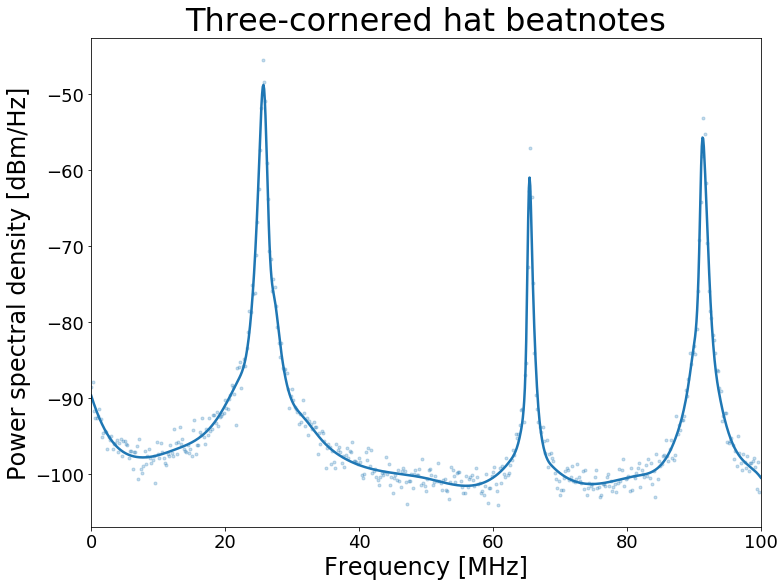

In [87]:
####################################################################################################
# Plot the enitre three-corner hat measurement spectrum
fulltrace = 'Data\\20190904-beatnote\\20190904-Full.csv' # Name of the file containing the trace to be plotted
trace = RSTrace(makefile(fulltrace)) # Import the data from the trace file
ax = traceplot(trace, 'TCH', 'Three-cornered hat beatnotes') # Produce a plot of the raw data
plt.show()

Plot of single beatnote spectrum

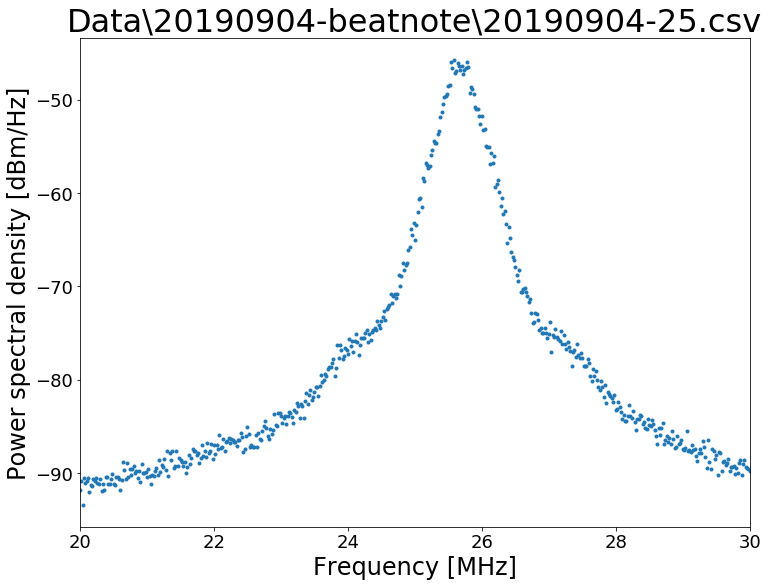

In [94]:
# Import and process the trace to be plotted
beatnote = 'Data\\20190904-beatnote\\20190904-25.csv' # Name of the file containing the trace to be plotted
trace = RSTrace(makefile(beatnote)) # Import the data from the trace file
ax = traceplot(trace, 'TCH', beatnote, interpol = False, opacity = 1) # Produce a plot of the raw data
plt.show()

Return a trace with Lorentzian fit, providing the file name, along with the centre frequency, width and 3dB width for the fit

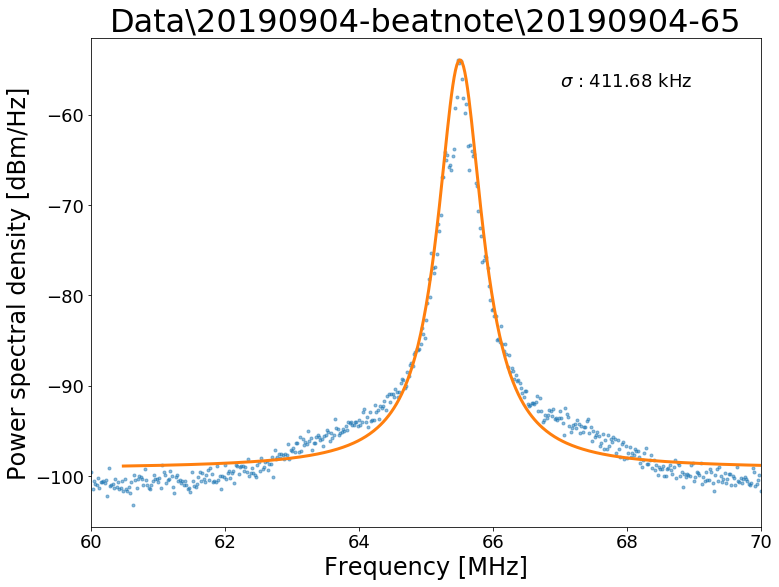

('Data\\20190904-beatnote\\20190904-65',
 65507071.15244995,
 411677.83131089545,
 219328.11244387925)

<Figure size 864x648 with 0 Axes>

In [7]:
fit_trace('Data\\20190904-beatnote\\20190904-65', 'Lorentzian')

Run the TCH analysis for test data

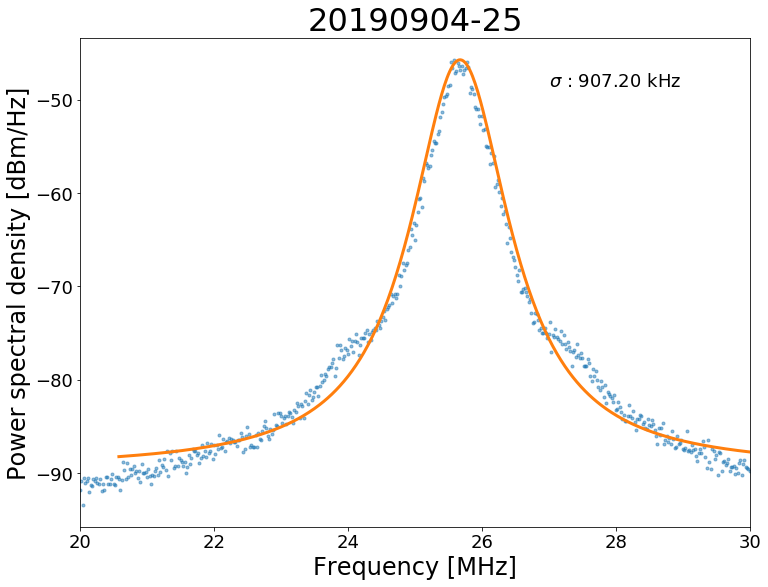

Peak found in trace 20190904-25 at 25.68 MHz with a width of 907.2 kHz and 3 dB width of 491.5 kHz



<Figure size 864x648 with 0 Axes>

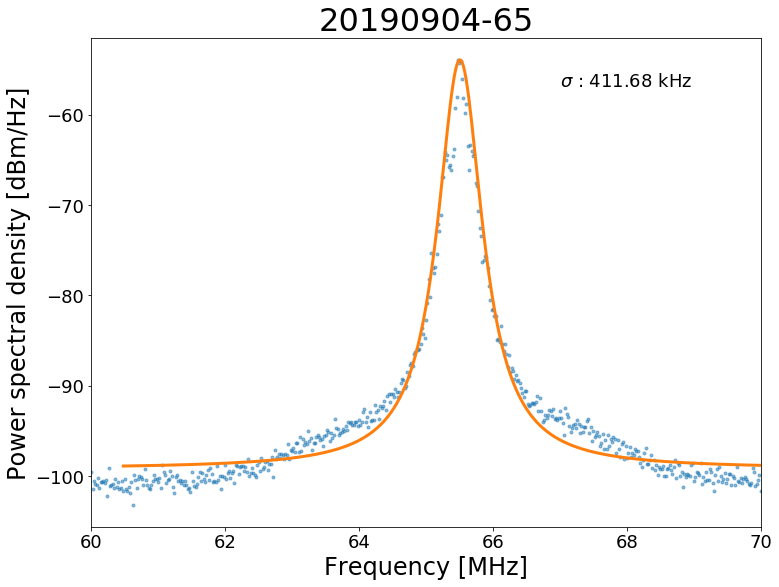

Peak found in trace 20190904-65 at 65.51 MHz with a width of 411.7 kHz and 3 dB width of 219.3 kHz



<Figure size 864x648 with 0 Axes>

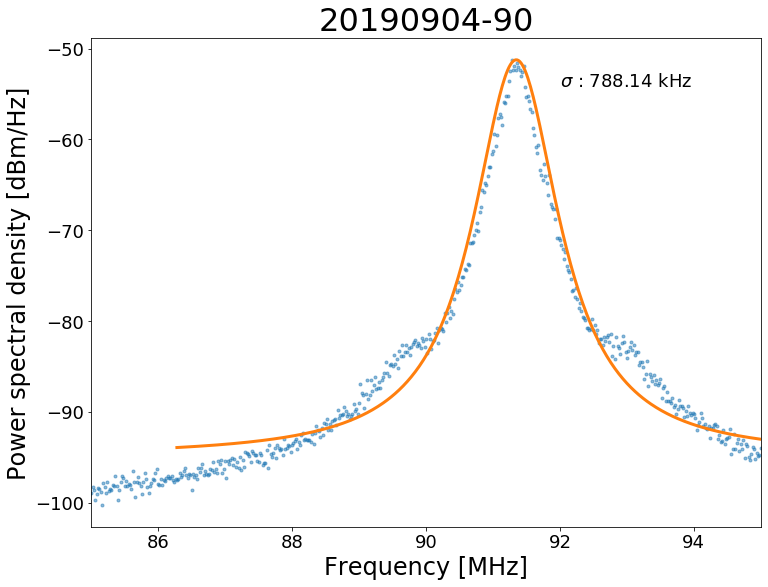

Peak found in trace 20190904-90 at 91.35 MHz with a width of 788.1 kHz and 3 dB width of 427.7 kHz



<Figure size 864x648 with 0 Axes>

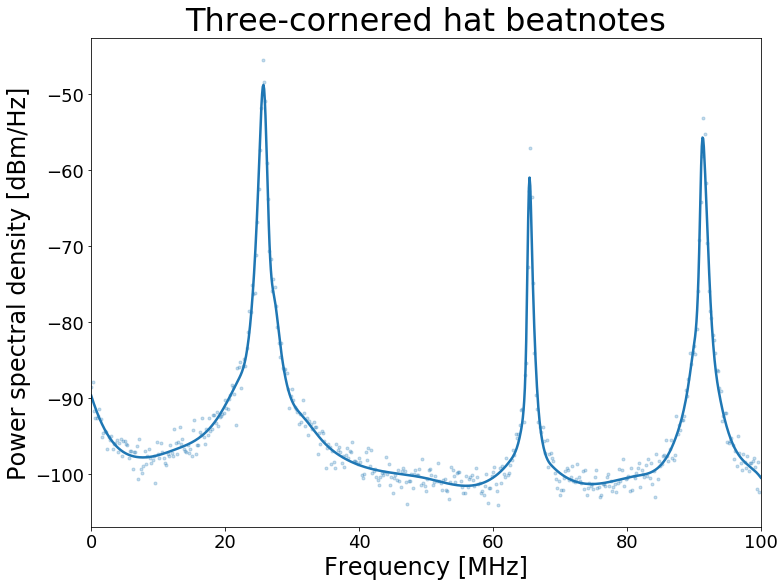

Laser frequencies determined to be -65.6 MHz and -91.3 MHz from pol. spec lock point

Laser linewidths determined to be nan kHz, 430.88 kHz, and 798.34 kHz for lasers 1, 2 and 3 respectively

Laser 3 dB linewidths determined to be nan kHz, 231.00 kHz, and 433.84 kHz for lasers 1, 2 and 3 respectively



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:454: RuntimeWarning: invalid value encountered in sqrt
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:460: RuntimeWarning: invalid value encountered in sqrt


<Figure size 864x648 with 0 Axes>

In [3]:
TCH_runner('Data\\20190904-beatnote')

Run the TCH analysis for data in another directory with differnt interpolation distance

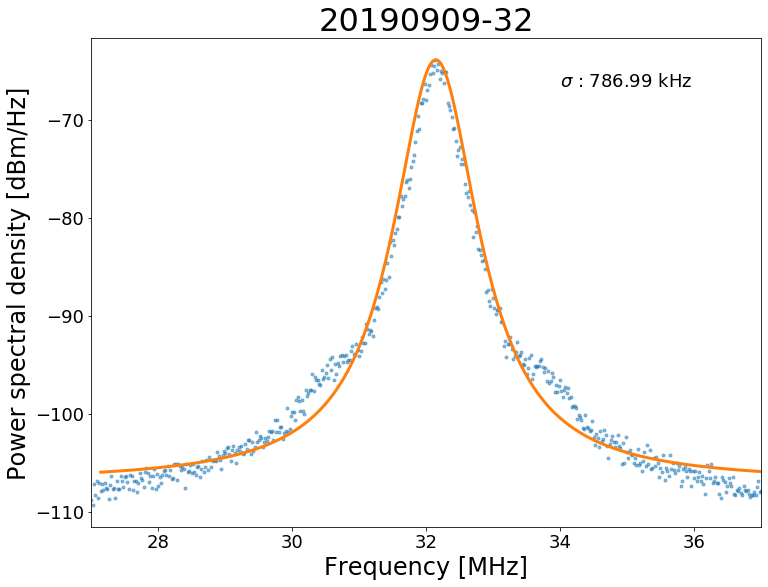

Peak found in trace 20190909-32 at 32.15 MHz with a width of 787.0 kHz and 3 dB width of 430.4 kHz



<Figure size 864x648 with 0 Axes>

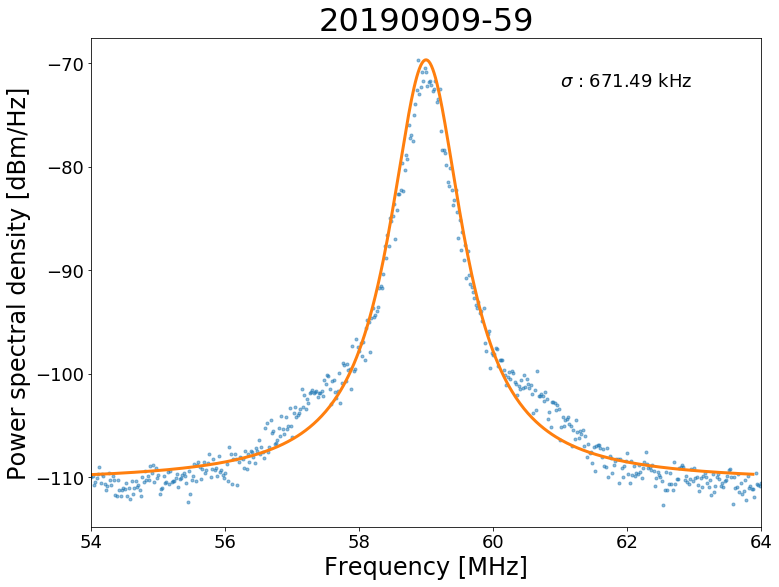

Peak found in trace 20190909-59 at 59.00 MHz with a width of 671.5 kHz and 3 dB width of 378.2 kHz



<Figure size 864x648 with 0 Axes>

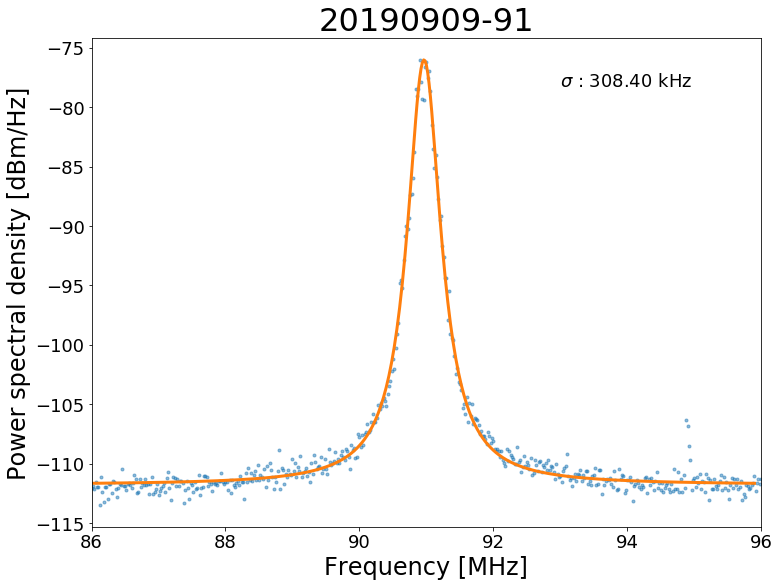

Peak found in trace 20190909-91 at 90.97 MHz with a width of 308.4 kHz and 3 dB width of 186.6 kHz



<Figure size 864x648 with 0 Axes>

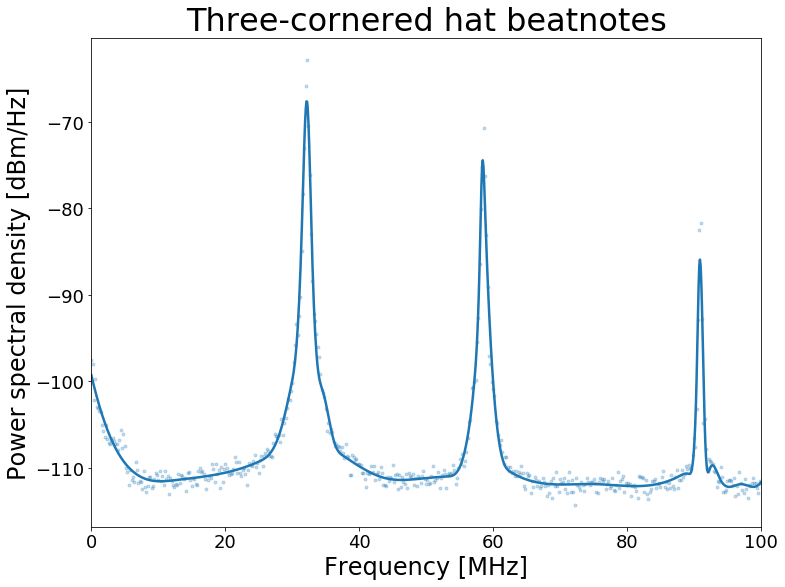

Laser frequencies determined to be -58.9 MHz and -91.0 MHz from pol. spec lock point

Laser linewidths determined to be nan kHz, 698.26 kHz, and 363.02 kHz for lasers 1, 2 and 3 respectively

Laser 3 dB linewidths determined to be nan kHz, 383.03 kHz, and 196.27 kHz for lasers 1, 2 and 3 respectively



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in sqrt
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:424: RuntimeWarning: invalid value encountered in sqrt


<Figure size 864x648 with 0 Axes>

In [8]:
TCH_runner('Data\\20190909_beatnote\\Set 1', 600)

# Usage for data analysis

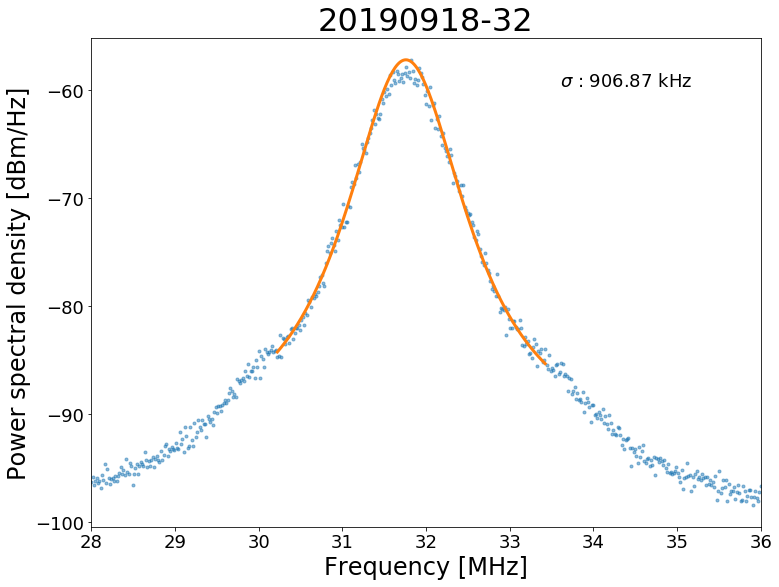

Peak found in trace 20190918-32 at 31.76 MHz with a width of 906.9 kHz and 3 dB width of 542.9 kHz



<Figure size 864x648 with 0 Axes>

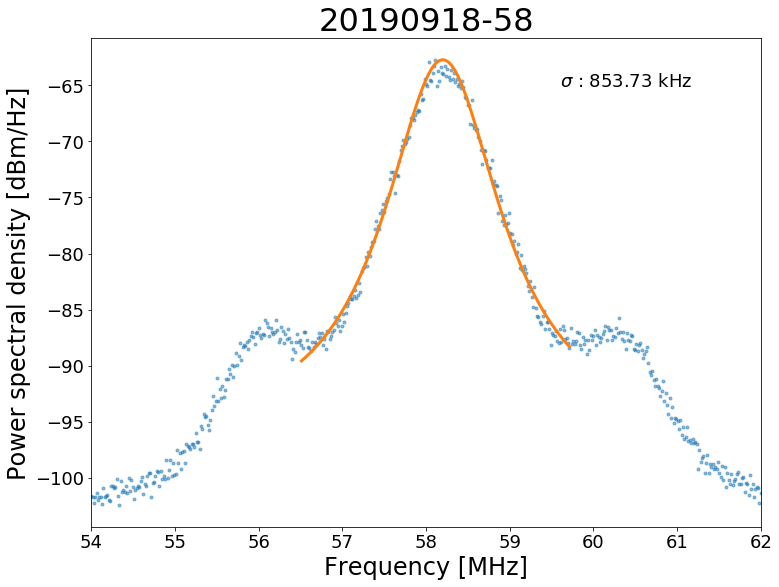

Peak found in trace 20190918-58 at 58.20 MHz with a width of 853.7 kHz and 3 dB width of 533.2 kHz



<Figure size 864x648 with 0 Axes>

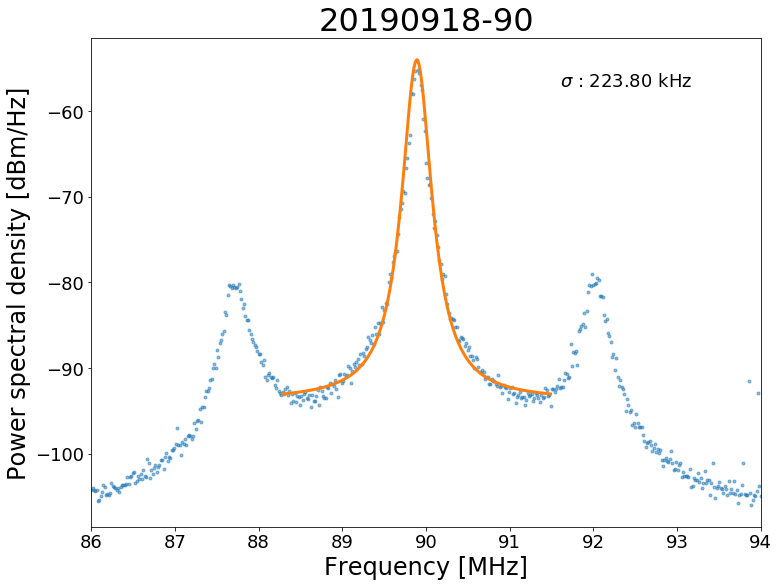

Peak found in trace 20190918-90 at 89.89 MHz with a width of 223.8 kHz and 3 dB width of 127.9 kHz



<Figure size 864x648 with 0 Axes>

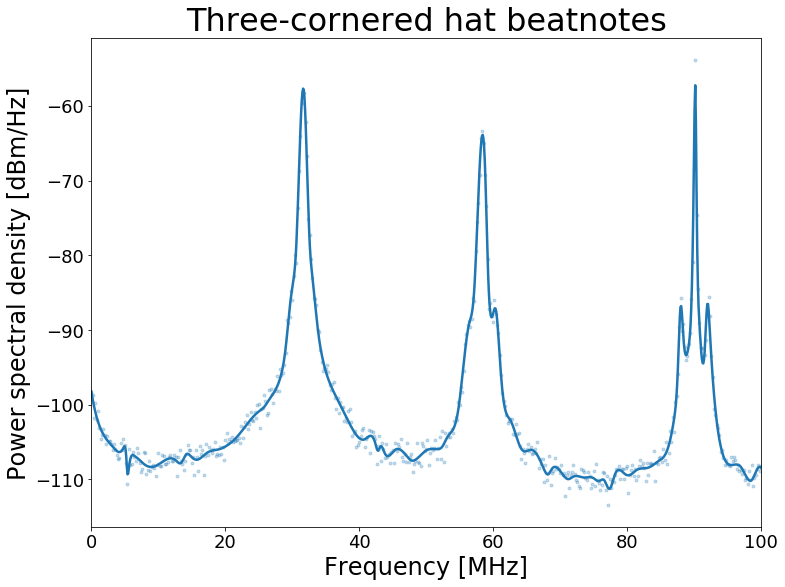

Laser frequencies determined to be -58.2 MHz and -89.9 MHz from pol. spec lock point

Laser linewidths determined to be nan kHz, 866.37 kHz, and 267.98 kHz for lasers 1, 2 and 3 respectively

Laser 3 dB linewidths determined to be 54.71 kHz, 530.43 kHz, and 115.58 kHz for lasers 1, 2 and 3 respectively



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:418: RuntimeWarning: invalid value encountered in sqrt


<Figure size 864x648 with 0 Axes>

In [9]:
TCH_runner('Data\\20190918_TCH\\Set1', 500, .4)